# Introduction


In this project, we will investigate adversarial perturbation attacks using the Fast Gradient Signed Method (FGSM) on Deep Neural Networks with the MNIST digits dataset as a benchmark. FGSM attack was one of the first and most popular attacks to fool a neural network. We will then evaluate adversarial retraining as a defense against adversarial perturbations.

## What is Adversarial Attacks?

Adversarial input attacks can be broadly classified into two types, one is non-targeted attack and the other is targeted attack.

* Non-targeted Attack: Aiming to fool the neural network and output a label different than the original one.
* Targeted Attack: Intentionally misleading the network to output a specific label designed by the attacker.

For example, a face recognition system for security entrance control:
* Non-targeted attacks should lead to denial of legal access.
* Targeted attacks bring the jeopardy of illegal entrance.

To fool the neural network, we need a special kind of input data called adversarial examples.

## What is Adversarial Example?

Adversarial examples are specialised inputs created with the purpose of confusing a neural network, resulting in the misclassification of a given input. These notorious inputs are indistinguishable to the human eye, but cause the network to fail to identify the contents of the image. There are several types of such attacks, however, here the focus is on the fast gradient sign method attack, which is a white box attack whose goal is to ensure misclassification. A white box attack is where the attacker has complete access to the model being attacked. One of the most famous examples of an adversarial image shown below is taken from the aforementioned paper.

![Adversarail Example](https://www.tensorflow.org/tutorials/generative/images/adversarial_example.png)

Here, starting with the image of a panda, the attacker adds small perturbations (distortions) to the original image, which results in the model labelling this image as a gibbon, with high confidence. The process of adding these perturbations is FGSM, which will be explained below.

## Fast Gradient Sign Method

The fast gradient sign method works by using the gradients of the neural network to create an adversarial example. For an input image, the method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. This new image is called the adversarial image. This can be summarised using the following expression:

**Non-targeted Attack**:

\begin{equation}
adv\_x = clip(x + \epsilon * sign(\nabla_xJ(\theta, x, y^*))) \tag{0}
\end{equation}

where
* $adv\_x$ : Adversarial image.
* $x$ : Original input image.
* $y^*$ : Original input label (true label)
* $\epsilon$ : Multiplier to ensure the perturbations are small.
* $\theta$ : Model parameters.
* $J$ : Loss.

**Targeted Attack**:

\begin{equation}
adv\_x = clip(x - \epsilon * sign(\nabla_xJ(\theta, x, y')))  \tag{1}
\end{equation}

where
* $adv\_x$ : Adversarial image.
* $x$ : Original input image.
* $y'$ : Target label (fake label)
* $\epsilon$ : Multiplier to ensure the perturbations are small.
* $\theta$ : Model parameters.
* $J$ : Loss.

An intriguing property here, is the fact that the gradients are taken with respect to the input image. This is done because the objective is to create an image that maximises the loss. A method to accomplish this is to find how much each pixel in the image contributes to the loss value, and add a perturbation accordingly. This works pretty fast because it is easy to find how each input pixel contributes to the loss by using the chain rule and finding the required gradients. Hence, the gradients are taken with respect to the image. In addition, since the model is no longer being trained (thus the gradient is not taken with respect to the trainable variables, i.e., the model parameters), and so the model parameters remain constant. The only goal is to fool an already trained model.

In the experiments section, we will try and fool a pretrained model, the model is a 2-layer DNN, pretrained on MNIST.

# Dataset


The MNIST dataset will be used in this project. The MNIST dataset is a commonly used 'toy' benchmarks for machine learning. It contains a train set of 60000 28x28 grayscale images of hand-drawn digits from 0-9, along with the associated labels. Also, it contains a test set of 10000 images. The dataset is available as part of the tensorflow package, which we will be using extensively in this project. For more details, please see the [link](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb#scrollTo=7NAbSZiaoJ4z) of how to use MNIST dataset.

Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). Convert the samples from integers to floating-point numbers:

In [1]:
import tensorflow as tf
import numpy as np

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11501568/11490434 [==============================] - 16s 1us/step


In [2]:
print("trainset shape: {}".format(x_train.shape))
print("testset shape: {}".format(x_test.shape))

trainset shape: (60000, 28, 28)
testset shape: (10000, 28, 28)


# Experiments

## Pretrain DNN on MNIST

The sample Google Colab [notebook](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb#scrollTo=7NAbSZiaoJ4z)
that implements a 2-layer DNN for MNIST digit classification. The DNN has a 784 (28x28) dimensional input, a 10-dimensional output (prediction probabilities for each of the 10 classes) and one hidden layer with 300 hidden neurons and ReLU activations. We will implement my attacks and defenses on this **baseline DNN**.

Let's build this baseline DNN. Build the `tf.keras.Sequential` model by stacking layers. Choose an optimizer and loss function for training:


In [3]:
baseline_dnn = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

Use SparseCategoricalCrossentropy loss function. The `losses.SparseCategoricalCrossentropy` loss takes a vector of logits and a `True` index and returns a scalar loss for each example. This loss is equal to the negative log probability of the true class:
It is zero if the model is sure of the correct class.

In [4]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

Train the baseline 2-layer DNN model.


In [5]:
baseline_dnn.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

baseline_dnn.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 1s 604us/step - loss: 0.2920 - accuracy: 0.9151
Epoch 2/5
1875/1875 [==============================] - 1s 560us/step - loss: 0.1395 - accuracy: 0.9592
Epoch 3/5
1875/1875 [==============================] - 1s 566us/step - loss: 0.1039 - accuracy: 0.9685
Epoch 4/5
1875/1875 [==============================] - 1s 562us/step - loss: 0.0869 - accuracy: 0.9733
Epoch 5/5
1875/1875 [==============================] - 1s 566us/step - loss: 0.0724 - accuracy: 0.9774


Evaluate the baseline model.

In [6]:
baseline_dnn.evaluate(x_test,  y_test, verbose=2)
baseline_dnn.trainable = False

313/313 - 0s - loss: 0.0740 - accuracy: 0.9788


The baseline image classifier is now trained to ~98% accuracy on MNIST dataset.

Since it is more intuitive for the baseline model to return a probability, we can wrap the trained model, and attach the softmax to it:

In [7]:
probability_baseline = tf.keras.Sequential([
  baseline_dnn,
  tf.keras.layers.Softmax()
])

In [8]:
# image: shape(1, 28, 28)
def baseline_model_predict_class(image):
  predition_prob = probability_baseline(image)
  prediction_class = tf.argmax(predition_prob, axis=1)
  return int(prediction_class)

Test baseline model on first 5 testcases in test set. We can see that all 5 images are classified correctly.

In [9]:
print('Baseline model prediction probability of first 5 testcases in test set:')
predition_prob = probability_baseline(x_test[:5])
print(predition_prob)

print('\nBaseline model prediction class of first 5 testcases in test set:')
prediction_class = tf.argmax(predition_prob, axis=1)
print(prediction_class)

for i in range(5):
  input_image = x_test[i:i+1]
  print("image_id: {} predict_class: {}".format(i, baseline_model_predict_class(input_image)))

print('\nTrue label of first 5 testcases:')
print(y_test[:5])

Baseline model prediction probability of first 5 testcases in test set:
tf.Tensor(
[[6.5293492e-08 8.0792297e-09 3.5260061e-06 1.7584956e-04 6.9055660e-12
  6.2371612e-08 9.5802120e-15 9.9981970e-01 1.3478412e-07 7.0686036e-07]
 [4.3187342e-07 1.9564592e-05 9.9989605e-01 1.4690252e-05 1.5745146e-17
  2.4111952e-05 3.8522372e-05 4.5025657e-11 6.5777049e-06 1.6644113e-14]
 [7.5374095e-07 9.9548209e-01 6.4541324e-04 1.3353461e-05 2.0584859e-05
  2.6922933e-06 1.7594139e-05 3.4593875e-03 3.5382007e-04 4.2024103e-06]
 [9.9978179e-01 2.9331651e-10 5.9576443e-05 3.6886871e-07 1.4272507e-08
  4.1426088e-06 1.5014342e-04 8.1923849e-07 3.5068823e-08 3.1172924e-06]
 [7.4349578e-06 1.3609661e-10 4.6789132e-06 1.4605087e-08 9.8779082e-01
  5.3250886e-07 3.4417915e-06 4.9037229e-05 8.0869694e-07 1.2143275e-02]], shape=(5, 10), dtype=float32)

Baseline model prediction class of first 5 testcases in test set:
tf.Tensor([7 2 1 0 4], shape=(5,), dtype=int64)
image_id: 0 predict_class: 7
image_id: 1 pred

## Implementing Fast Gradient Sign Method

Let's use a sample image from MNIST and create adversarial examples from it by FGSM. Here, I use the first image in train set.

In [10]:
# Helper function to preprocess the image
def preprocess(image):
  image = tf.cast(image, tf.float32)
  return image

# Helper function to get a 10-dim vector true label so that it can be inputted in loss function
def get_mnist_label(label):
  l = np.zeros((1, 10), dtype=float)
  l[0][label] = 1
  l = tf.convert_to_tensor(l)
  return l

print(get_mnist_label(5))

tf.Tensor([[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]], shape=(1, 10), dtype=float64)


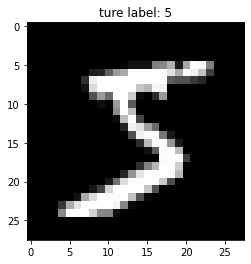

In [11]:
import matplotlib.pyplot as plt

image_index = 0
image = x_train[image_index]  # shape (28, 28)
plt.gray()
plt.title('ture label: {}'.format(y_train[image_index]))
plt.imshow(image)

To implement fast gradient sign method, the first step is to create perturbations which will be used to distort the original image resulting in an adversarial image. The gradients are taken with respect to the image.

In [12]:
cce_loss = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = probability_baseline(input_image)
    true_label = get_mnist_label(input_label)
    loss = cce_loss(true_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

The resulting perturbations can also be visualised.

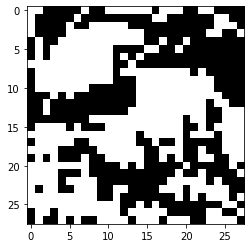

In [13]:
image_index = 0
image = x_train[image_index:image_index+1]  # shape (1, 28, 28)
image = preprocess(image)                   # shape (1, 28, 28)
label = y_train[image_index]

perturbations = create_adversarial_pattern(image, label)  # shape (1, 28, 28)
plt.imshow(perturbations[0])

Let's try this out for different values of epsilon and observe the resultant image attacked by FGSM based non-targeted attack. You'll notice that as the value of epsilon is increased, it becomes easier to fool the network. However, this comes as a trade-off which results in the perturbations becoming more identifiable.

In [14]:
# image: shape(1, 28, 28)
def display_images(image, description):
  plt.figure()
  plt.gray()
  plt.title(description)
  plt.imshow(image[0])
  plt.show()

To ensure the perturbations are small, we use $\epsilon$ as a multiplier ranged from 0.01 to 0.5 . 

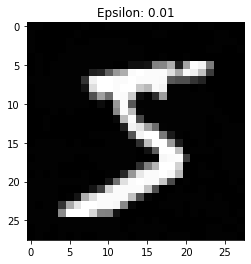

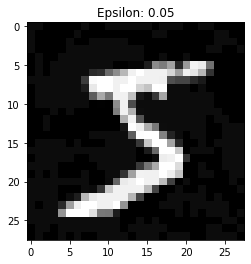

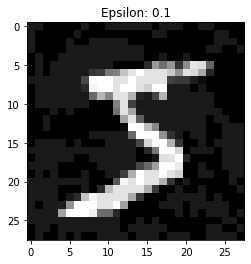

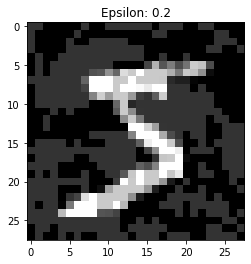

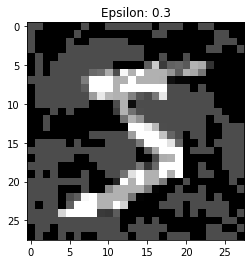

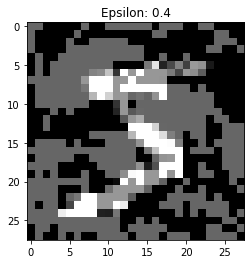

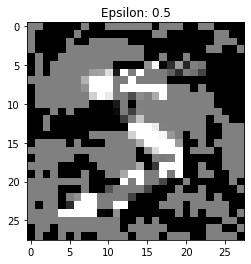

In [15]:
epsilons = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

for i, eps in enumerate(epsilons):
  adv_x = image + eps * perturbations
  adv_x = tf.clip_by_value(adv_x, 0, 1) # images are normalized to be in [0,1]
  description = "Epsilon: {}".format(epsilons[i])
  display_images(adv_x, description)

## FGSM based Untargeted Attacks

Step 1, our first goal to implement FGSM based untargeted attacks using images from the test set on the baseline DNN. That is, our goal is to adversarially perturb each image in the **test set** using the following values of parameter $\epsilon = \{0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5\}$. Report the success rate of our attack, i.e., the fraction of test images that were correctly classified by the baseline DNN that are mis-classified after adversarial perturbation, as a function of $\epsilon$. 

Implement FGSM based untargeted attacks according to [equation (0)](https://colab.research.google.com/drive/1hQTZLZ0KXHfWh0X2Ry-7BF8E5Wx7J5x0#scrollTo=XkzFmYcE4mYn&line=22&uniqifier=1).

In [16]:
# image: shape(1, 28, 28)
# label: int, 0~9
# adv_x: shape(1, 28, 28)
def fgsm_untargeted(image, true_label, eps=0.1):
  perturbations = create_adversarial_pattern(image, true_label)
  adv_x = image + eps * perturbations
  adv_x = tf.clip_by_value(adv_x, 0, 1)
  return adv_x

Adversarially perturb each image in the test set by FGSM based untargeted perturbations.. And calculate the success rate of FGSM based untargeted attack, i.e., the fraction of test images that were correctly classified by the baseline DNN that are mis-classified after adversarial perturbation.

In [17]:
def fgsm_untargeted_attack(epsilon):
  cnt_correct_classified_iamge = 0.0
  cnt_mis_classified_image = 0.0
  for i in range(x_test.shape[0]):
    image = x_test[i:i+1]
    before_predict_label = baseline_model_predict_class(image)
    image = preprocess(image)
    true_label = y_test[i]
    adv_x = fgsm_untargeted(image, true_label, eps=epsilon)  # shape (1, 28, 28)
    after_predict_label = baseline_model_predict_class(adv_x)

    if before_predict_label == true_label:
      cnt_correct_classified_iamge += 1.0
      if after_predict_label != true_label:
        cnt_mis_classified_image += 1.0
    
  attack_success_rate = cnt_mis_classified_image / cnt_correct_classified_iamge
  return cnt_correct_classified_iamge, cnt_mis_classified_image, attack_success_rate


untargeted_attack_success_rates = []
for eps in epsilons:
  cnt_correct_classified_iamge, cnt_mis_classified_image, attack_success_rate = fgsm_untargeted_attack(eps)
  print("Epsilon: {}\nNumber of correctly classified images: {}\nNumber of mis-classified images after attack: {}\nAttack Success Rate: {}\n".format(eps, cnt_correct_classified_iamge, cnt_mis_classified_image, attack_success_rate))
  untargeted_attack_success_rates.append(attack_success_rate * 100)

Epsilon: 0.01
Number of correctly classified images: 9788.0
Number of mis-classified images after attack: 181.0
Attack Success Rate: 0.018492031058438906

Epsilon: 0.05
Number of correctly classified images: 9788.0
Number of mis-classified images after attack: 3223.0
Attack Success Rate: 0.3292807519411524

Epsilon: 0.1
Number of correctly classified images: 9788.0
Number of mis-classified images after attack: 7747.0
Attack Success Rate: 0.7914793624846751

Epsilon: 0.2
Number of correctly classified images: 9788.0
Number of mis-classified images after attack: 9505.0
Attack Success Rate: 0.9710870453616673

Epsilon: 0.3
Number of correctly classified images: 9788.0
Number of mis-classified images after attack: 9540.0
Attack Success Rate: 0.9746628524724152

Epsilon: 0.4
Number of correctly classified images: 9788.0
Number of mis-classified images after attack: 9541.0
Attack Success Rate: 0.9747650183898652

Epsilon: 0.5
Number of correctly classified images: 9788.0
Number of mis-classi

Draw a line graph of epsilon versus attack success rate.

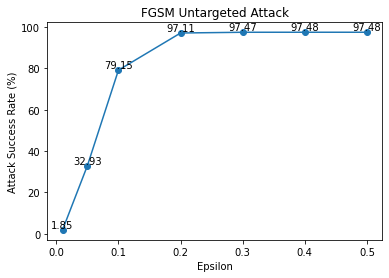

In [18]:
def plot_attack_success_rate(epsilons, attack_success_rates, title):
  assert len(epsilons) == len(attack_success_rates), 'Please check the length of attack_success_rates!'

  plt.figure()
  plt.plot(epsilons, attack_success_rates, marker='o')
  plt.xlabel("Epsilon")
  plt.ylabel("Attack Success Rate (%)")

  attack_success_rates = [float("{:.2f}".format(rate)) for rate in attack_success_rates]

  for a, b in zip(epsilons, attack_success_rates):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=10)

  plt.title(title)
  plt.show()

title = "FGSM Untargeted Attack"
plot_attack_success_rate(epsilons, untargeted_attack_success_rates, title)

We can notice that as the value of epsilon is increased, the attack success rate is increased, it becomes easier to fool the network.

## FGSM based Targeted Attacks

Step 2, we will repeat Step 1 above, except this time perform *targeted* attacks where digit $i$ is classified as $(i+1)\%10$ on the baseline DNN. (Here, $i$ refers to the true ground-truth label of the test images, and we can assume that the attacker has access to these labels). Test image with label $i$ will be perturbed with label $(i+1)\%10$.

As before, use the following values of the parameter $\epsilon = \{0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5\}$. Report the attack’s success rate as a function of parameter $\epsilon$ where success rate is defined as the fraction of test images that were that were correctly classified by the baseline DNN that are mis-classified after adversarial perturbations with label $(i+1)\%10$.

Implement FGSM based targeted attacks according to [equation (1)](https://colab.research.google.com/drive/1hQTZLZ0KXHfWh0X2Ry-7BF8E5Wx7J5x0#scrollTo=XkzFmYcE4mYn&line=22&uniqifier=1).

In [19]:
# image: shape(1, 28, 28)
# label: int, 0~9
# adv_x: shape(1, 28, 28)
def fgsm_targeted(image, fake_label, eps=0.1):
  perturbations = create_adversarial_pattern(image, fake_label)
  adv_x = image - eps * perturbations
  adv_x = tf.clip_by_value(adv_x, 0, 1)
  return adv_x

Adversarially perturb each image in the test set by FGSM based targeted perturbations. And calculate the success rate of FGSM based untargeted attack, i.e., the fraction of test images that were correctly classified by the baseline DNN that are mis-classified after adversarial perturbation.

Epsilon: 0.01
Number of correctly classified images: 9788.0
Number of mis-classified images after attack: 18.0
Attack Success Rate: 0.0018389865140988966

Epsilon: 0.05
Number of correctly classified images: 9788.0
Number of mis-classified images after attack: 1255.0
Attack Success Rate: 0.12821822639967306

Epsilon: 0.1
Number of correctly classified images: 9788.0
Number of mis-classified images after attack: 3097.0
Attack Success Rate: 0.31640784634246016

Epsilon: 0.2
Number of correctly classified images: 9788.0
Number of mis-classified images after attack: 4275.0
Attack Success Rate: 0.43675929709848793

Epsilon: 0.3
Number of correctly classified images: 9788.0
Number of mis-classified images after attack: 4184.0
Attack Success Rate: 0.4274621986105435

Epsilon: 0.4
Number of correctly classified images: 9788.0
Number of mis-classified images after attack: 3989.0
Attack Success Rate: 0.40753984470780547

Epsilon: 0.5
Number of correctly classified images: 9788.0
Number of mis-cl

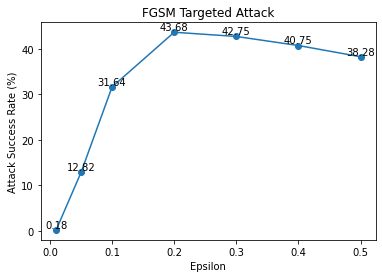

In [20]:
def fgsm_targeted_attack(epsilon):
  cnt_correct_classified_iamge = 0.0
  cnt_mis_classified_image = 0.0
  for i in range(x_test.shape[0]):
    image = x_test[i:i+1]
    before_predict_label = baseline_model_predict_class(image)
    image = preprocess(image)
    true_label = y_test[i]
    fake_label = (true_label + 1) % 10
    adv_x = fgsm_targeted(image, fake_label, eps=epsilon)  # shape (1, 28, 28)
    after_predict_label = baseline_model_predict_class(adv_x)

    if before_predict_label == true_label:
      cnt_correct_classified_iamge += 1.0
      if after_predict_label != true_label and after_predict_label == fake_label:
        cnt_mis_classified_image += 1.0
    
  attack_success_rate = cnt_mis_classified_image / cnt_correct_classified_iamge
  return cnt_correct_classified_iamge, cnt_mis_classified_image, attack_success_rate


targeted_attack_success_rates = []
for eps in epsilons:
  cnt_correct_classified_iamge, cnt_mis_classified_image, attack_success_rate = fgsm_targeted_attack(eps)
  print("Epsilon: {}\nNumber of correctly classified images: {}\nNumber of mis-classified images after attack: {}\nAttack Success Rate: {}\n".format(eps, cnt_correct_classified_iamge, cnt_mis_classified_image, attack_success_rate))
  targeted_attack_success_rates.append(attack_success_rate * 100)

title = "FGSM Targeted Attack"
plot_attack_success_rate(epsilons, targeted_attack_success_rates, title)


We can notice that as the value of epsilon is increased, the attack success rate goes up first and then goes down slowly.

## Adversarial Retraining against Untargeted FGSM Attacks

Step 3, we can assume $\epsilon = 0.1$ throughout. To defend against adversarial perturbations, the defender adversarially perturbs each image in her **training set** using the attacker’s strategy in Step 1. She then appends the adversarially perturbed images to her training set, but using their *correct* labels. Then, the defender retrains the baseline DNN with a new training dataset containing both images from the original training dataset and the new adversarially perturbed images. We call the new DNN the **adversarially retrained DNN**.

* Report the classification accuracy of the adversarially retrained DNN on the original test dataset that contains only clean inputs.
* Is the adversarially retrained DNN robust against adversarial perturbations? Implement FGSM based untargeted attacks using images from the clean test set on the adversarially retrained DNN. Report the success rate of your attack.

As a defender now, adversarially perturbs each image in the training set using the attacker's strategy in Step 1 and append the adversarially perturbed images to her training set with their true labels.

In [21]:
epsilon = 0.1
delta_x_train = np.zeros(x_train.shape)

for i in range(x_train.shape[0]):
  image = x_train[i:i+1]    # shape (1, 28, 28)
  image = preprocess(image)
  true_label = y_train[i]
  adv_x = fgsm_untargeted(image, true_label, eps=epsilon)  # shape (1, 28, 28)
  delta_x_train[i] = adv_x[0]


new_x_train = np.append(x_train, delta_x_train, axis=0)
new_y_train = np.append(y_train, y_train, axis=0)
assert new_x_train.shape[0] == 120000, "Please make sure new train set has 120000 samples!"
assert new_y_train.shape[0] == 120000, "Please make sure new train set has 120000 samples!"

print("new train set images shape: {}".format(new_x_train.shape))
print("new train set labels shape: {}".format(new_y_train.shape))

new train set images shape: (120000, 28, 28)
new train set labels shape: (120000,)


Retrain the baseline DNN with new training set containing both images from the original training dataset and the new adversarially perturbed images.

In [22]:
adv_retrained_dnn = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

adv_retrained_dnn.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

adv_retrained_dnn.fit(new_x_train, new_y_train, epochs=5)

Epoch 1/5
3750/3750 [==============================] - 2s 594us/step - loss: 0.1886 - accuracy: 0.9452
Epoch 2/5
3750/3750 [==============================] - 2s 586us/step - loss: 0.0776 - accuracy: 0.9769
Epoch 3/5
3750/3750 [==============================] - 2s 558us/step - loss: 0.0584 - accuracy: 0.9819
Epoch 4/5
3750/3750 [==============================] - 2s 560us/step - loss: 0.0480 - accuracy: 0.9851
Epoch 5/5
3750/3750 [==============================] - 2s 561us/step - loss: 0.0400 - accuracy: 0.9872


Evaluate the classification accuracy of the adversarially retrained DNN on the original test dataset that contains only clean inputs.

In [23]:
adv_retrained_dnn.evaluate(x_test, y_test, verbose=2)

313/313 - 0s - loss: 0.0813 - accuracy: 0.9752


[0.08128883689641953, 0.9751999974250793]

Since it is more intuitive for the adversarially retrained DNN model to return a probability, we can wrap the retrained model, and attach the softmax to it:

In [24]:
probability_adv_retrained_dnn = tf.keras.Sequential([
  adv_retrained_dnn,
  tf.keras.layers.Softmax()
])

In [25]:
# image: shape(1, 28, 28)
def adv_retrained_dnn_predict_class(image):
  predition_prob = adv_retrained_dnn(image)
  prediction_class = tf.argmax(predition_prob, axis=1)
  return int(prediction_class)

Test adversarially retrained DNN model on first 5 testcases in test set. We can see that all 5 test images are classified correctly.

In [26]:
for i in range(5):
  input_image = x_test[i:i+1]
  print("image_id: {} predict_class: {} true_label: {}".format(i, adv_retrained_dnn_predict_class(input_image), y_test[i]))

image_id: 0 predict_class: 7 true_label: 7
image_id: 1 predict_class: 2 true_label: 2
image_id: 2 predict_class: 1 true_label: 1
image_id: 3 predict_class: 0 true_label: 0
image_id: 4 predict_class: 4 true_label: 4


Let's see if the adversarially retrained DNN can resist attack from adversarial perturbations. Implement FGSM based untargeted attacks using images from the clean test set on the adversarially retrained DNN. Calculate the success rate of the attack.

Epsilon: 0.01
Number of correctly classified images: 9752.0
Number of mis-classified images after attack: 0.0
Attack Success Rate: 0.0

Epsilon: 0.05
Number of correctly classified images: 9752.0
Number of mis-classified images after attack: 2.0
Attack Success Rate: 0.00020508613617719443

Epsilon: 0.1
Number of correctly classified images: 9752.0
Number of mis-classified images after attack: 3.0
Attack Success Rate: 0.00030762920426579164

Epsilon: 0.2
Number of correctly classified images: 9752.0
Number of mis-classified images after attack: 8.0
Attack Success Rate: 0.0008203445447087777

Epsilon: 0.3
Number of correctly classified images: 9752.0
Number of mis-classified images after attack: 29.0
Attack Success Rate: 0.002973748974569319

Epsilon: 0.4
Number of correctly classified images: 9752.0
Number of mis-classified images after attack: 133.0
Attack Success Rate: 0.013638228055783429

Epsilon: 0.5
Number of correctly classified images: 9752.0
Number of mis-classified images afte

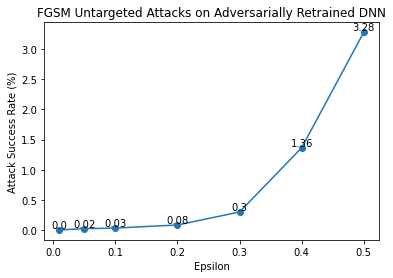

In [27]:
def fgsm_untargeted_attack_retrained(epsilon):
  cnt_correct_classified_iamge = 0.0
  cnt_mis_classified_image = 0.0
  for i in range(x_test.shape[0]):
    image = x_test[i:i+1]
    before_predict_label = adv_retrained_dnn_predict_class(image)
    image = preprocess(image)
    true_label = y_test[i]
    adv_x = fgsm_untargeted(image, true_label, eps=epsilon)  # shape (1, 28, 28)
    after_predict_label = adv_retrained_dnn_predict_class(adv_x)

    if before_predict_label == true_label:
      cnt_correct_classified_iamge += 1.0
      if after_predict_label != true_label:
        cnt_mis_classified_image += 1.0
    
  attack_success_rate = cnt_mis_classified_image / cnt_correct_classified_iamge
  return cnt_correct_classified_iamge, cnt_mis_classified_image, attack_success_rate


untargeted_attack_success_rates_retrained = []
for eps in epsilons:
  cnt_correct_classified_iamge, cnt_mis_classified_image, attack_success_rate = fgsm_untargeted_attack_retrained(eps)
  print("Epsilon: {}\nNumber of correctly classified images: {}\nNumber of mis-classified images after attack: {}\nAttack Success Rate: {}\n".format(eps, cnt_correct_classified_iamge, cnt_mis_classified_image, attack_success_rate))
  untargeted_attack_success_rates_retrained.append(attack_success_rate * 100)


title = "FGSM Untargeted Attacks on Adversarially Retrained DNN"
plot_attack_success_rate(epsilons, untargeted_attack_success_rates_retrained, title)

We can notice that as the value of epsilon is increased, the attack success rate remains very low (under 4.2%). When $\epsilon = \{0.01, 0.05, 0.1\}$, the number of mis-classified images is 0, which means the adversarial attack didn't fool the dnn at all. The adversarially retrained DNN is robust against adversarial perturbations.

# References
* Goodfellow I J, Shlens J, Szegedy C. Explaining and harnessing adversarial examples[J]. arXiv preprint arXiv:1412.6572, 2014.
* https://www.tensorflow.org/tutorials/generative/adversarial_fgsm
* https://github.com/tensorflow/cleverhans
* https://harvard-iacs.github.io/2019-CS109B/lecture/lab21/AdversarialNN/